In [3]:
# Importing necessary libraries
import pandas as pd
import torch
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import Trainer, TrainingArguments
from transformers import DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader

In [5]:
# Checking device (GPU/CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [7]:
# Loading and viewing the dataset
data = pd.read_csv("Bitext_Sample_Customer_Service_Training_Dataset.csv")
data.head()

,flags,utterance,category,intent
0,BM,I have problems with canceling an order,ORDER,cancel_order
1,BIM,how can I find information about canceling ord...,ORDER,cancel_order
2,B,I need help with canceling the last order,ORDER,cancel_order
3,BIP,could you help me cancelling the last order I ...,ORDER,cancel_order
4,B,problem with cancelling an order I made,ORDER,cancel_order


In [9]:
# Viewing the shape of the dataset
print(f"Shape of dataset: {data.shape}")

Shape of dataset: (8175, 4)


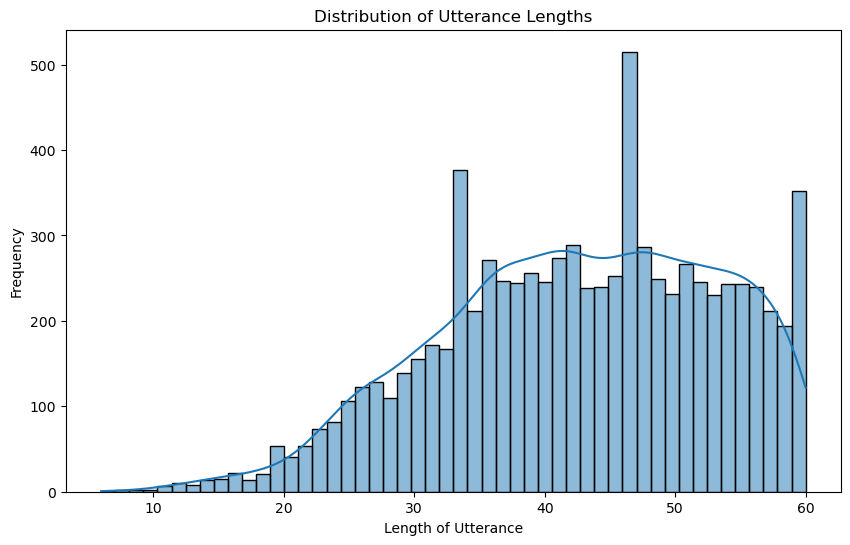

In [11]:
# Calculating the length of each utterance
data['utterance_length'] = data['utterance'].apply(len)

# Visualizing the distribution of utterance lengths
plt.figure(figsize=(10, 6))
sns.histplot(data['utterance_length'], kde=True, bins=50)
plt.title('Distribution of Utterance Lengths')
plt.xlabel('Length of Utterance')
plt.ylabel('Frequency')
plt.show()

In [13]:
# Detecting outliers based on utterance length using IQR
Q1 = data['utterance_length'].quantile(0.25)
Q3 = data['utterance_length'].quantile(0.75)
IQR = Q3 - Q1

# Filtering rows where utterance length is outside the IQR range
outliers = data[(data['utterance_length'] < (Q1 - 1.5 * IQR)) | (data['utterance_length'] > (Q3 + 1.5 * IQR))]

# Removing outliers based on the IQR for utterance length
data = data[~((data['utterance_length'] < (Q1 - 1.5 * IQR)) | (data['utterance_length'] > (Q3 + 1.5 * IQR)))]

data = data.drop('utterance_length', axis=1)
# Verifying the shape of the cleaned data
print(f"Shape of cleaned dataset: {data.shape}")

Shape of cleaned dataset: (8168, 4)


In [15]:
# Preprocessing the dataset
# Encoding labels as integers
label_encoder = LabelEncoder()
data['encoded_intent'] = label_encoder.fit_transform(data['intent'])

In [17]:
# Splitting the dataset into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['utterance'], data['encoded_intent'], test_size=0.2, random_state=42)

In [19]:
# Loading tokenizer for a transformer model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [21]:
# Tokenizing the text data
def tokenize_texts(texts):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)

In [23]:
# Creating a custom PyTorch Dataset
class IntentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = IntentDataset(train_encodings, train_labels.values)
val_dataset = IntentDataset(val_encodings, val_labels.values)

In [27]:
# Loading the DistilBERT base model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label_encoder.classes_))

# Verify the initialized layers
print(model.classifier)
model.to(device)

Linear(in_features=768, out_features=27, bias=True)


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [29]:
# Calculating accuracy of the model
accuracy_metric = evaluate.load("accuracy")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    accuracy = accuracy_metric.compute(predictions=preds, references=labels)
    return {"accuracy": accuracy["accuracy"]}

In [33]:
# Defining training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [35]:
# Training the model
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.218500,0.162974,0.993880
2,0.030700,0.029470,0.997552
3,0.022000,0.021491,0.998164


TrainOutput(global_step=1227, training_loss=0.5023208462011551, metrics={'train_runtime': 1873.927, 'train_samples_per_second': 10.46, 'train_steps_per_second': 0.655, 'total_flos': 101475922925520.0, 'train_loss': 0.5023208462011551, 'epoch': 3.0})

In [37]:
# Saving the fine-tuned model
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")
print("Model fine-tuned and saved successfully!")

Model fine-tuned and saved successfully!
